In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

try:
    df = pd.read_csv('news_dataset.csv')
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'news_dataset.csv' not found. Please ensure the file is uploaded or run the data generation script first.")

✅ Dataset loaded successfully.


In [8]:
from google.colab import files

# This will trigger the file selection dialog
uploaded = files.upload()

# Optional: Verify the file is uploaded and print the filename
for filename in uploaded.keys():
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

🔄 Training Classification Model...
✅ Model Trained.

   PERSONALIZED NEWS RECOMMENDATION ENGINE

Available Categories: sports, politics, health, tech
Enter your preferred category: sports

🔎 Retrieving top news for SPORTS...

Top 5 Personalized News Recommendations:
------------------------------------------------------------------------------------------------------------------------
TITLE                                              | CATEGORY   | URL
------------------------------------------------------------------------------------------------------------------------
UFC president Dana White does not expect punish..  | sports     | https://www.cnn.com/2023/01/12/sport/dana-white-ufc-domestic-violence-spt-intl/index.html
Uneasiness Over A.I. Spending Looms Over Market..  | business   | https://www.nytimes.com/2025/11/20/business/stocks-ai-global.html
Saudi Arabia, Once Shunned, Has Corporate Titan..  | business   | https://www.nytimes.com/2025/11/19/business/saudi-investment-forum-

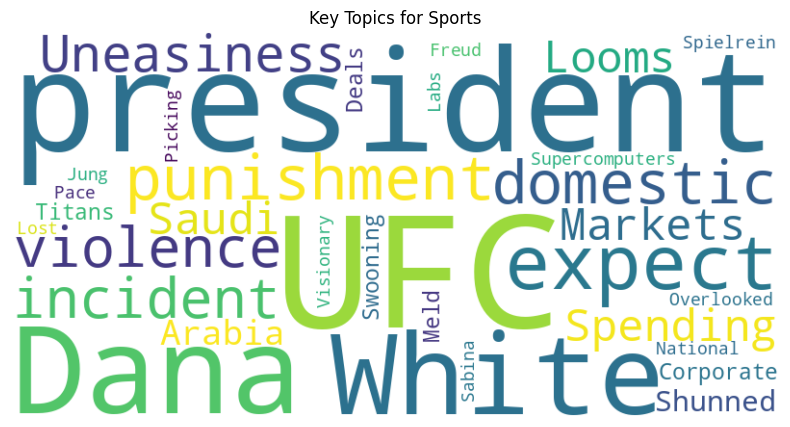

In [9]:

print("🔄 Training Classification Model...")
X = df['title']
y = df['category']

# Pipeline: TF-IDF Vectorizer -> Naive Bayes Classifier
model = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    MultinomialNB()
)
model.fit(X, y)
print("✅ Model Trained.")

print("\n" + "="*50)
print("   PERSONALIZED NEWS RECOMMENDATION ENGINE")
print("="*50)

print("\nAvailable Categories: sports, politics, health, tech")
user_pref = input("Enter your preferred category: ").lower().strip()

# Default to 'sports' if input is invalid
valid_categories = ['sports', 'politics', 'health', 'tech']
if user_pref not in valid_categories:
    print(f"⚠️ Input '{user_pref}' not recognized. Defaulting to 'sports'.")
    user_pref = 'sports'

print(f"\n🔎 Retrieving top news for {user_pref.upper()}...")

df['predicted_category'] = model.predict(df['title'])
probs = model.predict_proba(df['title'])

# Find the column index for the user's preferred category
classes = model.named_steps['multinomialnb'].classes_
pref_index = list(classes).index(user_pref) if user_pref in classes else 0

# Assign confidence score
df['confidence_score'] = probs[:, pref_index]

alpha = 0.6  # Weight for AI Confidence
beta  = 0.3  # Weight for Category Match
gamma = 0.1  # Weight for Recency (Newness)

def calculate_final_score(row):
    conf = row['confidence_score']
    match = 1.0 if row['predicted_category'] == user_pref else 0.0
    recency = 1.0 / (1.0 + row['days_old']) # Newer news gets higher score

    return (alpha * conf) + (beta * match) + (gamma * recency)

df['final_score'] = df.apply(calculate_final_score, axis=1)

# Sort by Score
results = df.sort_values(by='final_score', ascending=False).head(5)

print(f"\nTop 5 Personalized News Recommendations:")
print("-" * 120)
print(f"{'TITLE':<50} | {'CATEGORY':<10} | {'URL'}")
print("-" * 120)

for index, row in results.iterrows():
    # Truncate title for cleaner display
    title_disp = (row['title'][:47] + '..') if len(row['title']) > 47 else row['title']
    print(f"{title_disp:<50} | {row['category']:<10} | {row['url']}")
print("-" * 120)

print("\nGenerating Topic WordCloud...")
text_combined = " ".join(results['title'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Key Topics for {user_pref.capitalize()}")
plt.show()